# 1. Exploratory Data Analysis
First, let's take a look at the data we are given. From the website, we already know:
   - The columns (geohash6, day, timestamp, demand)
   - That the day is the same over all locatins (day one always coresponds to the same date)
   - Geohashes are anonymised, meaning that the absolute location is not of much value, but the adjacency is maintained, meaning that the relational geoinformation betwean locations can be used
   - Missing rows exist, but can be considered/filled with zero -> correspond to zero demand
   
After taking a general look in section 1.1, section 1.2 will look at demand over time (inter- and intra days), and section 1.3 will look the geoinformation and demand over those locations.

In [1]:
# Import of all packages needed over this notebook
import json
import random  # For sampling
import datetime as dt
from time import sleep

import pandas as pd
import seaborn as sns  # Standard visualisations
import matplotlib.pyplot as plt  # For sub- and wider plots 
from socket import timeout  # Using timeout error for exceptions on geohash
import swifter  # For easy parallelization of panda applys

import geohash  # To decode Geohashes
from geopy.geocoders import Nominatim  # To convert lat/long to addresses
from geopy.distance import distance  # For distance between two coordinates

sns.set()  # For prettier plots
geolocator = Nominatim(user_agent="hQ0PeXSNGppwoFjrtOUhJW95G5URrD8p")

d:\google drive\audienceserv\jupyter\venv\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## 1.1 General analysis of the dataset


In [2]:
df_train = pd.read_csv('training.csv')
df_train.head(2)

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721


In [3]:
print(f"The dataset starts at day {df_train.day.max()} and ends with day {df_train.day.max()}")
print(f"In total, we are dealing with {len(df_train.geohash6.unique())} different locations")

The dataset starts at day 61 and ends with day 61
In total, we are dealing with 1329 different locations


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206321 entries, 0 to 4206320
Data columns (total 4 columns):
geohash6     object
day          int64
timestamp    object
demand       float64
dtypes: float64(1), int64(1), object(2)
memory usage: 128.4+ MB


## 1.2 Demand over time

Fidings about the data set to this point:
  - Demand is aggregated over the entire dataset, not the region
  - There is no directly obvious pattern regarding weekdays
  - Many time values are missing
  - For same lovations, he demand is relativly steady on a day-sto-day basis

In [5]:
# Processing

# Timestamp is a string, for that reason, we will convert it together with the day into a datetime format for easier analysis
# We simply assume that day 1 is the 1st of March, while ignoring all the other things 
# that would normally come with that date (weekday, holidays etc.)
def combine_datetime(row):
    # Initialise the date with the time
    date = dt.datetime.strptime(row.timestamp, '%H:%M')
    if row.day <= 31:
        month = 3
        day = row.day
    else:
        month = 4
        day = row.day - 31
    date = date.replace(year=2019, month=month, day=day)
    
    return date

df_train['datetime'] = df_train.swifter.apply(lambda row: combine_datetime(row), axis=1)

# Numerate weekdays 1-7, note that 1 does not indicate Sunday or Monday, but for now could be any day of the week
df_train['weekday'] = (df_train.day % 7) + 1

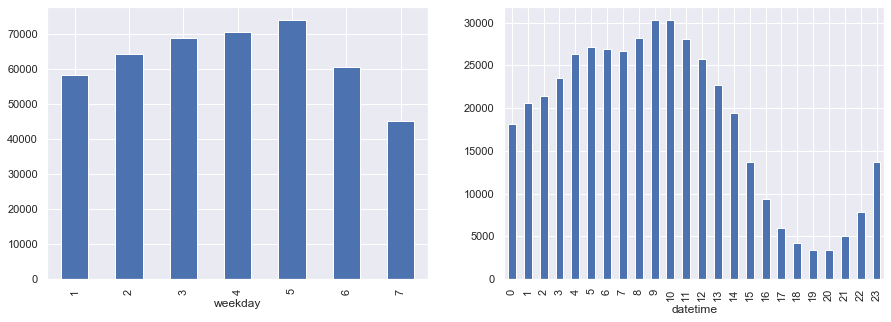

In [6]:
# Plot aggregated demand per weekday and through the day
fig, ax = plt.subplots(1, 2, figsize=(15,5))
df_train.groupby(['weekday']).sum().demand.plot(kind='bar', ax=ax[0])
df_train.groupby(df_train['datetime'].dt.hour).sum().demand.plot(kind='bar', ax=ax[1])


#fig, ax = pyplot.subplots(figsize=(16,4))
#sns.barplot(data=df_sample, x='weekday', y='demand', ax=ax)

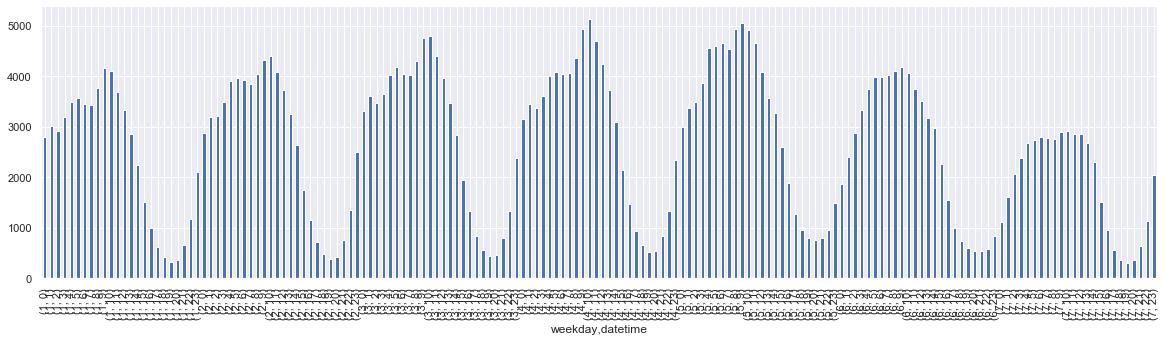

In [7]:
# Lastly, let's look at those two charts combined
fig, ax = plt.subplots(figsize=(20,5))
df_train.groupby([df_train['weekday'], df_train['datetime'].dt.hour]).sum().demand.plot(kind='bar', ax=ax)

### 1.2.1 Results
Looking at the daily results, the 7th day catches the eye with a significantly lower demand (~20% under the second lowest day, which is day 1). For now, it is not nessesary for this challange to attribute a certain day to it. However, my interpretation is that day 7 corresponds to Sunday, where generally less activities take place and the majority does not have to go to work.

The second noticable this is that the time seems to be shifted. In my opinion it is highly unlikely that the demand from 4am to 5am is ten times higher than the demand from 7pm to 8pm. In my optinion, the time might be 8 hours off, which would result in peak demand from 5pm to 7pm, corresponding to the evening rush hour.

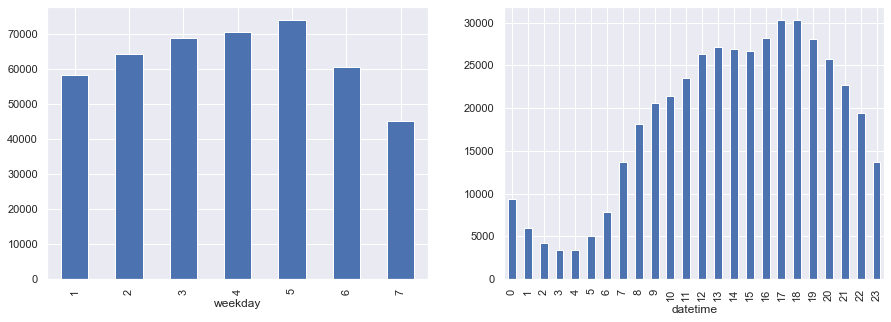

In [8]:
# Demand plots when shifted by 5 hours
df_temp = df_train.copy()
df_temp['datetime'] = df_temp['datetime'] +  dt.timedelta(hours=8)

fig, ax = plt.subplots(1, 2, figsize=(15,5))
df_temp.groupby(['weekday']).sum().demand.plot(kind='bar', ax=ax[0])
df_temp.groupby(df_temp['datetime'].dt.hour).sum().demand.plot(kind='bar', ax=ax[1])

## 1.3 Demand by location

The first step is to convert the geo hashes into geo-coordinates. Afterwards, we will plot them in a scatter plot to get an idea of their spacing and see if there are local hot-spot.

Note: A  single geohash with precision 6 spans over an area of ~1.22km x 0.61km

In [9]:
# Fastest implementation, first create a dataframe with geo information for each unique gehash, then merge it with the training data
geo_cache = [{'geohash6': ghash, 'lat': geohash.decode(ghash)[0], 'lon': geohash.decode(ghash)[1]} for ghash in df_train.geohash6.unique()]
df_train = df_train.merge(pd.DataFrame(geo_cache), how='left', on='geohash6')

In [24]:
lat_dist = distance((df_temp['lat'].max(), 0), (df_temp['lat'].min(), 0))
lon_dist = distance((0, df_temp['lon'].max()), (0, df_temp['lon'].min()))
print(f"All geo-locations are within an area of {round(lat_dist.meters, 2)}m x {round(lon_dist.meters, 2)}m")

All geo-locations are within an area of 27335.52m x 42804.74m


In [10]:
# Function for groupby's - lat and lon should be the same within the group while grouping by hash
def aggregate_demand(x):
    x['demand'] = x['demand'].sum()
    x['lat'] = x['lat'].min()
    x['lon'] = x['lon'].min()
    return x

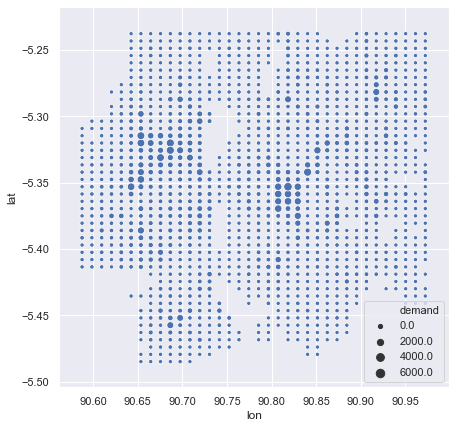

In [12]:
# Plot general demand aggregated by location over the full time
df_temp = df_train.groupby(['geohash6'])\
                  .apply(aggregate_demand)\
                  .drop_duplicates(subset=['geohash6'])

fig, ax = plt.subplots(figsize=(7,7))  # Not true to scale
sns.scatterplot(x='lon', y='lat', size='demand', data=df_temp)

### 1.3.1 Results
The plots reveal that, on one hand, there are multiple hot spots inside the data and on the other hand, spots with 0 demand over the full timeframe inside the dataset. Due to the otherwise regularity of the locations given, it should be save to assume that these empty spots in the middle really have 0 demand are not simply missing. Reason for this could be, i.e., larger lakes.

It would be interesting to have an interactive map showing how demand differs over the day in the different areas. For exmaple the demand in living quarters should be higher during the morning (people ordering Grabs to go to work), and higher within the office areas during the late afternoon/early evening.

In [6]:
# We can append the missing datetime vaules by comparing the existing ones for each
# geo-location with a date_range
missing_rows = list()
for ghash in tqdm(df_train.geohash6.unique()):
    missing_dates = pd.date_range(start=dt.date(2019, 3, 1), 
                                  end=dt.datetime(2019, 4, 30, 23, 45, 0), 
                                  freq='15min')\
                      .difference(df_train[df_train.geohash6 == 'qp02yy'].datetime)
  
    for date in missing_dates:
        day = abs((date - dt.datetime(2019, 3, 1, 0, 0)).days) + 1
        missing_rows.append({'geohash6': ghash, 
                             'day': day, 
                             'timestamp': date.strftime('%H:%M'), 
                             'demand': 0,
                             'datetime': date})

# Combine the dataset with the missing rows
df_train = pd.concat([df_train, pd.DataFrame(missing_rows)])

d:\google drive\audienceserv\jupyter\venv\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

